<a href="https://colab.research.google.com/github/vinejain/multilingual_feedback_multilabel_classification/blob/master/VJ_XLNet_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

REFERENCE: https://towardsdatascience.com/multi-label-text-classification-with-xlnet-b5f5755302df

In [1]:
!pip install transformers

     |████████████████████████████████| 778kB 5.6MB/s 
     |████████████████████████████████| 1.1MB 30.8MB/s 
     |████████████████████████████████| 890kB 42.4MB/s 
     |████████████████████████████████| 3.0MB 53.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=8a4416322e36a4e2cd5757b89d81f015b8bc061c3f4e5dc3da68370f71da75ce
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla T4


In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Import Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
!ls content/drive/My Drive/thesis_data

ls: cannot access 'content/drive/My': No such file or directory
ls: cannot access 'Drive/thesis_data': No such file or directory


In [77]:
train = pd.read_csv('/content/drive/My Drive/thesis_data/df-training.csv')
test = pd.read_csv('/content/drive/My Drive/thesis_data/en-test-oracle.csv')
#train = train[['ID', 'cleaned_text', 'Lab1']]

In [79]:
temp= pd.DataFrame()
temp['ID'] = train['ID']
temp['comment_text'] = train['comment_text']
dum_df1 = pd.get_dummies(train['Lab1'])
result = temp.join(dum_df1)
#result = pd.merge(temp, dum_df1, how='inner', on=None, left_on=None, right_on=None)
train = result 

In [64]:
test.head()

,ID,comment_text
0,00001cee341fdb12,Let it work for few days
1,0000247867823ef7,You can't go wrong!!!
2,00013b17ad220c46,Just got back from three fantastic nights in B...
3,00017563c3f7919a,One of the cups supplied had a major crack in ...
4,00017695ad8997eb,I mean...your job is to accomodate guest's boo...


In [80]:
train.head()

,ID,comment_text,bug,comment,complaint,meaningless,request,undetermined
0,0000997932d777bf,The give me a room which was so smelly and the...,0,0,1,0,0,0
1,000103f0d9cfb60f,Unfortunately there was a mix up with my Passp...,0,0,0,1,0,0
2,000113f07ec002fd,The (basic) room was comfortable and not too s...,0,1,0,0,0,0
3,0001b41b1c6bb37e,"Our primary concierge, [name[, was amazing in ...",0,1,0,0,0,0
4,0001d958c54c6e35,We booked through Priceline (paying more than ...,0,0,1,0,0,0


In [ ]:
# get small sample of train to try
#train = train.sample(n=4000)
#test = test.sample(n=4000)

## Preprocess Data

In [66]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [67]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [68]:
train_text_list = train["comment_text"].values
test_text_list = test["comment_text"].values

In [69]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [81]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=250)
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=250)
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)
# add input ids and attention masks to the dataframe
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks

test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

TypeError: ignored

## Train, Valid Split

In [ ]:
# train valid split
train, valid = train_test_split(train, test_size=0.2, random_state=42)

X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

## Create Dataloaders

In [ ]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

## Train Model from Scratch

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [ ]:
num_epochs=2

cwd = os.getcwd()
#model_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/Models/xlnet_toxic.bin")
model_save_path = output_model_file = os.path.join(cwd, 'Models')
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.010420773481600918
Valid loss: 0.007291894177906215


Epoch:  50%|█████     | 1/2 [04:24<04:24, 264.08s/it]

Saving model at epoch 0 with validation loss of 0.007291894177906215


Train loss: 0.009093092445109505
Valid loss: 0.004926562225446105


Epoch: 100%|██████████| 2/2 [08:53<00:00, 266.73s/it]

Saving model at epoch 1 with validation loss of 0.004926562225446105




Text(0.5, 1.0, 'Loss vs Number of Epochs')

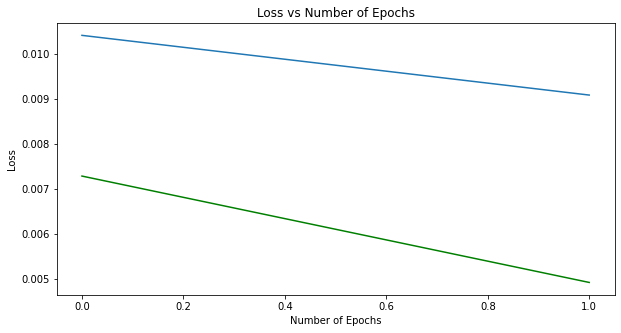

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## Train Model From Previous Checkpoint

In [ ]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "Models")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

In [ ]:
num_epochs=2
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              train_loss_set=train_loss_hist,\
                                              valid_loss_set=valid_loss_hist,\
                                              lowest_eval_loss=lowest_eval_loss,\
                                              start_epoch=start_epoch,\
                                              device="cuda")

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.007371408380822686
Valid loss: 0.00488330636289902


Epoch:  50%|█████     | 1/2 [04:28<04:28, 268.52s/it]

Saving model at epoch 1 with validation loss of 0.00488330636289902


Train loss: 0.004554962594406789
Valid loss: 0.003951068182941526


Epoch: 100%|██████████| 2/2 [08:57<00:00, 268.86s/it]

Saving model at epoch 2 with validation loss of 0.003951068182941526




Text(0.5, 1.0, 'Loss vs Number of Epochs')

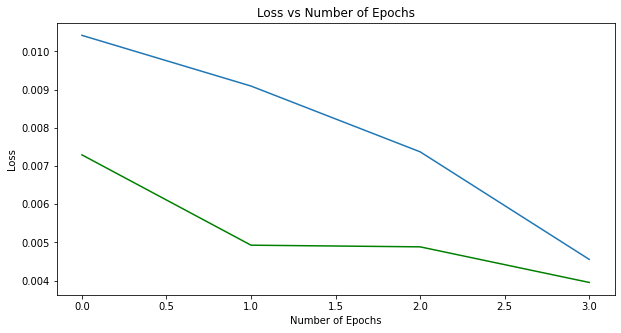

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## Get Predictions

In [ ]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[9.50991750e-01, 3.78098935e-01, 8.93275380e-01, 6.08538240e-02,
        8.87068629e-01, 2.68079907e-01],
       [5.84324040e-02, 3.98063130e-04, 7.20409025e-03, 4.04099585e-04,
        1.83351431e-02, 9.66909865e-04],
       [8.55864108e-01, 1.36265725e-01, 7.41217673e-01, 1.71298664e-02,
        6.81628823e-01, 9.05558467e-02],
       ...,
       [6.00380749e-02, 4.19914402e-04, 7.59293372e-03, 4.22291021e-04,
        1.90596879e-02, 1.00642839e-03],
       [6.16392717e-02, 4.43357509e-04, 8.09313636e-03, 4.39466967e-04,
        1.98520012e-02, 1.05249684e-03],
       [7.82498300e-01, 8.00403357e-02, 6.32270813e-01, 1.57097690e-02,
        6.01962745e-01, 7.05697462e-02]])

In [ ]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

test["toxic"] = pred_probs[:,0]
test["severe_toxic"] = pred_probs[:,1]
test["obscene"] = pred_probs[:,2]
test["threat"] = pred_probs[:,3]
test["insult"] = pred_probs[:,4]
test["identity_hate"] = pred_probs[:,5]

In [ ]:
test.head()

,comment_text,features,masks,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,,,
8cb0447cb2b313b9,YOU SUCK WILD PENIS,"[44, 11989, 2914, 19721, 4, 3, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0.950992,0.378099,0.893275,0.060854,0.887069,0.268080
a55f91a3b6f1370f,Nothing seens to have happened on this in a wh...,"[805, 566, 23, 22, 47, 1525, 31, 52, 25, 24, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.058432,0.000398,0.007204,0.000404,0.018335,0.000967
ed0becbcda372b82,== What the hell... == \n\n First you convict ...,"[5847, 5383, 113, 18, 3678, 9, 9, 9, 5847, 538...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.855864,0.136266,0.741218,0.017130,0.681629,0.090556
ee5e929aa77182b3,== Electoral system? == \n\n Am I missing the ...,"[5847, 5383, 6382, 277, 82, 5847, 5383, 569, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.056273,0.000370,0.006663,0.000379,0.017369,0.000909
128b19da40c41c7b,"::Sure, I've added a comment, but I'm finding ...","[17, 60, 60, 13991, 19, 17, 150, 26, 189, 462,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.056105,0.000368,0.006609,0.000378,0.017239,0.000905


In [ ]:
test_to_csv = test.reset_index()
test_to_csv.head()

,id,comment_text,features,masks,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,8cb0447cb2b313b9,YOU SUCK WILD PENIS,"[44, 11989, 2914, 19721, 4, 3, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0.950992,0.378099,0.893275,0.060854,0.887069,0.268080
1,a55f91a3b6f1370f,Nothing seens to have happened on this in a wh...,"[805, 566, 23, 22, 47, 1525, 31, 52, 25, 24, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.058432,0.000398,0.007204,0.000404,0.018335,0.000967
2,ed0becbcda372b82,== What the hell... == \n\n First you convict ...,"[5847, 5383, 113, 18, 3678, 9, 9, 9, 5847, 538...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.855864,0.136266,0.741218,0.017130,0.681629,0.090556
3,ee5e929aa77182b3,== Electoral system? == \n\n Am I missing the ...,"[5847, 5383, 6382, 277, 82, 5847, 5383, 569, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.056273,0.000370,0.006663,0.000379,0.017369,0.000909
4,128b19da40c41c7b,"::Sure, I've added a comment, but I'm finding ...","[17, 60, 60, 13991, 19, 17, 150, 26, 189, 462,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.056105,0.000368,0.006609,0.000378,0.017239,0.000905


In [ ]:
cwd = os.getcwd()
pred_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/Data/toxic_1_epoch.csv")
test_to_csv[["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].to_csv(pred_save_path, index=False)

In [ ]:
np.round(pred_probs)

array([[1., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0.]])

In [ ]:
from google.colab import files

test.to_csv('test_sample.csv')
files.download('test_sample.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>